# "End-to-end Pytorch model in five minutes"
> "Standardising dataloaders, model, training and validation - so you don't have to"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, pytorch, cnn, computer vision]
- hide: true
- search_exclude: true

In [3]:
# hide
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Download and import data
All datasets are subclasses of `torch.utils.data.Dataset`; that is, they have `_len_` and `_getitem_` methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel.

In [4]:
data_path = '/Users/charlesoneill/DataspellProjects/pytorch'

In [5]:
kmnist = datasets.KMNIST(data_path, train=True, download=True,
                       transform = transforms.Compose([
                           transforms.ToTensor()]))
kmnist_val = datasets.KMNIST(data_path, train=False, download=True,
                           transform = transforms.ToTensor())

In [6]:
# find the normalisation values
# we stack all the tensors along an extra dimension
imgs = torch.stack([img_t for img_t, _ in kmnist], dim=3)
imgs.shape

torch.Size([1, 28, 28, 60000])

In [11]:
imgs.view(1, -1).mean(dim=1)

tensor([0.1918])

In [12]:
# compute mean and std per channel
mean = imgs.view(1,-1).mean(dim=1) 
std = imgs.view(1,-1).std(dim=1)
mean, std

(tensor([0.1918]), tensor([0.3483]))

In [13]:
# normalised data
t_kmnist = datasets.KMNIST(data_path, train=True,
                                       download=False, transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307),
                                                                (0.3081))
                                       ]))

t_kmnist_val = datasets.KMNIST(data_path, train=False,
                                           download=False, transform=transforms.Compose([
                                               transforms.ToTensor()]))

In [14]:
train_loader = torch.utils.data.DataLoader(kmnist, batch_size=128,
                                           shuffle=True,
                                           num_workers=1)
val_loader = torch.utils.data.DataLoader(kmnist_val, batch_size=128,
                                         shuffle=False,
                                         num_workers=1)

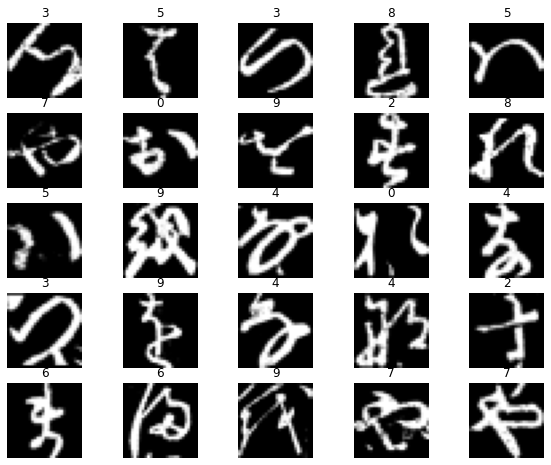

In [15]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(t_kmnist), size=(1,)).item()
    img, label = t_kmnist[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.savefig("samples_kmnist.png", dpi=300)
plt.show()

## Model

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, 
                               stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1,
                               padding=2)
        self.layer1 = nn.Sequential(self.conv1, nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(self.conv2, nn.ReLU(), nn.MaxPool2d(kernel_size=2))         
        self.out = nn.Linear(32*7*7, 10) # output 10 classes
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # flatten the output of conv2 to (batch_size, 32*7*7)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output

In [20]:
img, _ = next(iter(train_loader))
img = img[0]
img.shape

torch.Size([1, 28, 28])

In [21]:
model = Net()
model(img.unsqueeze(0)).shape

torch.Size([1, 10])

## Training

In [26]:
import datetime

def training_loop(n_epochs, model, loss_fn, optimiser, train_loader):
    model.train()
    total_step = len(train_loader)
    for n in range(1, n_epochs+1):
        for i, (imgs, labels) in enumerate(train_loader):
            output = model(Variable(imgs)) # forward pass
            loss = loss_fn(output, Variable(labels)) # compute loss
            optimiser.zero_grad() # reset gradients
            loss.backward() # backpropagation
            optimiser.step() # update the weights
        if (i+1) % (n_epochs/10) == 0:
            print ('{} Epoch {}, Loss: {:.4f}' 
                    .format(datetime.datetime.now(), n, 
                            loss.item()))

In [27]:
model = Net()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [28]:
training_loop(
    n_epochs = 10,
    model = model,
    loss_fn = loss_fn,
    optimiser = optimiser,
    train_loader = train_loader
)

2022-02-16 19:06:35.367592 Epoch 1, Loss: 0.2144
2022-02-16 19:07:15.944256 Epoch 2, Loss: 0.0703
2022-02-16 19:07:56.383608 Epoch 3, Loss: 0.1678
2022-02-16 19:08:37.393362 Epoch 4, Loss: 0.0894
2022-02-16 19:09:18.199468 Epoch 5, Loss: 0.1410
2022-02-16 19:09:58.719223 Epoch 6, Loss: 0.0583
2022-02-16 19:10:38.622223 Epoch 7, Loss: 0.1134
2022-02-16 19:11:18.310361 Epoch 8, Loss: 0.0553
2022-02-16 19:11:57.956218 Epoch 9, Loss: 0.0592
2022-02-16 19:12:37.695169 Epoch 10, Loss: 0.0749


## Validate

In [31]:
def validate(model, train_loader, val_loader):       
    model.eval() # set to eval mode to avoid batchnorm
    with torch.no_grad(): # avoid calculating gradients
        correct, total = 0, 0
        for images, labels in val_loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('VALIDATION SET ACCURACY: %.2f' % accuracy)

In [32]:
validate(model, train_loader, val_loader)

VALIDATION SET ACCURACY: 0.94
